# ENSF 612 Final Project: Music Analytics and Recommendations
Group Members:
- Nathan de Oliveira
- Rana El Sadig
- Destin Saba
- Cole Cathcart
- David Nguyen

# Introduction and Motivation

In the era of digital media, music streaming platforms have transformed how we discover and enjoy music. Services like Spotify have millions of tracks available at our fingertips, making music recommendation systems essential for enhancing user experience. Recognizing the significance of these systems, our team chose to explore the “Spotify Tracks, Genre, Audio Features” dataset from Kaggle (https://www.kaggle.com/datasets/pepepython/spotify-huge-database-daily-charts-over-3-years/data) using PySpark to analyze trends and build a music recommendation model.

Our motivation for selecting this dataset is rooted in a desire to engage with a more intriguing and relatable subject matter than the typical technical datasets we’ve encountered in previous classes. Music is a universal language, and understanding how recommendation systems work within this context is both exciting and relevant. Music recommendation models are increasingly important as the amount of data generated online continues to grow, impacting how users interact with streaming services.

The primary objectives of our project are twofold:
1. Data Analysis: We aim to understand trends within the music data by examining how different genres relate to specific audio feature metrics. For example, we want to investigate whether certain genres consistently exhibit higher danceability scores or how energy levels vary across genres.
2. Model Building: Utilizing machine learning techniques, we plan to develop two ML models: A popularity predictor model which will estimate a song's popularity based on other metrics, and a music recommendation model which will leverage clustering to suggest similar tracks to a given song.

Our project focuses on mainstream music, as the dataset predominantly features popular tracks. While we have considered algorithms like K-Nearest Neighbors for recommendation, we will determine the most suitable machine learning methods as we progress, ensuring they align with our dataset characteristics and project goals.

This notebook is organized into the following sections:
1. Data collection
2. Inspection & Validation
3. Transformation & Processing
4. Exploratory Data Analysis
5. Data Filtering
6. Popularity Prediction
7. K-NN Clustering/song reccomender

## Instructions to Run
1. Unzip the 'Music_Database.zip' file from the d2l submission and place the 'Music_Database.csv' file in the same directory as this notebook.
2. Run all cells.

Note: The end of this notebook features 2 interfaces that require keyboard input from the user to show recommended songs. Please follow the instructions in those cells to view the song recommendation functionality.

# Data Collection

In [1]:
from pyspark.sql import SparkSession


if SparkSession._instantiatedSession is not None:
    print("An existing SparkSession is detected.")
    SparkSession._instantiatedSession.stop()


# Initialize a Spark session
# Start a new Spark session
spark = SparkSession.builder \
    .appName("MusicDataAnalysisProject") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.yarn.executor.memoryOverhead", "2g") \
    .getOrCreate()


spark.sparkContext.setLogLevel("DEBUG")

# Path to your CSV file
csv_path = "Music_Database.csv"


music_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("quote", '"') \
    .option("escape", '"') \
    .csv(csv_path)

music_df = music_df.withColumnRenamed("Country", "Country0")

# Show the first few rows to verify
music_df.show()

+-----------+--------------------+------------------+---------------+--------------------+------------+-----------------+----------------+--------+--------------------+------------+------------+---------------+------------------+------------------+---+--------+----+-----------+-------------------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+----------+-------------------+------------+-------------------+-------------------+------------------+-------------+-------------------+------------------+-------------------+-----------+------------------+-------------+--------

The data is read from a CSV file named Music_Database.csv into a Spark DataFrame. The Spark session is initialized with specific memory configurations to handle large datasets efficiently. The data ingestion process includes options to ensure the header is recognized, the schema is inferred automatically, and special characters such as quotes are properly handled. Finally, the first few rows of the dataset are displayed to verify successful data loading.

# Data Inspection and Validation

From a preliminary glance we can identify the following traits about this data:
* The dimensionality is quite high; this is partly because it seems many of the columns have already been one-hot encoded. We  may want to limit the scope of this dataset, perhaps by constricting only to songs which charted in North America
* Some of the columns contain string data. Some of these are categorical and may have already been encoded. Others, like song `Title`, are not feasible to encode and won't be useful to our models. We will handle these during feature selection
* Some of the columns contain null values. We will need to decide on a filling or discarding rule based on the type of each column.

Upon inspecting the schema, we can see many numerical columns are of type string. Therefore, we will convert them to numeric types later on during Data Transformation.

In [2]:
# Print the schema of the DataFrame
music_df.printSchema()

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: string (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acoustics: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveliness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: 

Next, we check for null and duplicates in the dataset. Also, check the distribution of popularity scores because later we will categorize the data by low, medium, and high popularity levels.

In [3]:
from pyspark.sql.functions import col, sum, count, when
# Count null values in each column
null_counts = music_df.select([count(when(col(c).isNull(), c)).alias(c) for c in music_df.columns])
null_counts.show()

# Check for duplicates
duplicate_count = music_df.count() - music_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

# Check popularity range for validity (e.g., ensure no extreme outliers)
music_df.select("Popularity").describe().show()


+--------+---+----------+-----+------+------------+-----+----------------+--------+------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-----+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+-----+-----+-----+-----+------------+-------+-----+-----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+---------------+-----+--------------+-------------+--

# Data Transformation and Preprocessing

Many columns in our dataset are represented as strings even though the data is implied to be numeric. We can solve this issue by casting the columns to their respective numeric types.

In [4]:
from pyspark.sql.functions import col, lit, datediff, to_date, length, concat, regexp_replace, count, when

# List of columns to cast to integer or double as appropriate
int_columns = ["Track_number", "Tracks_in_album", "time_signature", "Argentina", "Australia", "Austria",
               "Belgium", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Denmark", "Ecuador",
               "Finland", "France", "Germany", "Global", "Indonesia", "Ireland", "Italy", "Malaysia",
               "Mexico", "Netherlands", "New Zealand", "Norway", "Peru", "Philippines", "Poland",
               "Portugal", "Singapore", "Spain", "Sweden", "Switzerland", "Taiwan", "Turkey", "UK", "USA"]

double_columns = ["Popularity", "Artist_followers", "danceability", "energy", "key", "loudness",
                  "mode", "speechiness", "acoustics", "instrumentalness", "liveliness", "valence",
                  "tempo", "duration_ms", "Days_since_release", "syuzhet_norm", "bing_norm", "afinn_norm",
                  "nrc_norm", "syuzhet", "bing", "afinn", "nrc", "anger", "anticipation", "disgust", "fear",
                  "joy", "sadness", "surprise", "trust", "negative", "positive", "n_words", "anger_norm",
                  "anticipation_norm", "disgust_norm", "fear_norm", "joy_norm", "sadness_norm", "surprise_norm",
                  "trust_norm", "negative_norm", "positive_norm", "anger_norm2", "anticipation_norm2",
                  "disgust_norm2", "fear_norm2", "joy_norm2", "sadness_norm2", "surprise_norm2", "trust_norm2",
                  "negative_norm2", "positive_norm2", "negative_bog_jr", "positive_bog_jr", "Bayes",
                  "Negative_Bayes", "Neutral_Bayes", "Positive_Bayes", "Desire", "Explore", "Fun",
                  "Hope", "Love", "Nostalgia", "Thug", "bing_norm_negative"]

casted_df = music_df

# Cast columns to integer
for column in int_columns:
    casted_df = casted_df.withColumn(column, col(column).cast("int"))

# Cast columns to double
for column in double_columns:
    casted_df = casted_df.withColumn(column, col(column).cast("double"))

# Verify the updated schema
casted_df.printSchema()

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: double (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: string (nullable = true)
 |-- Track_number: integer (nullable = true)
 |-- Tracks_in_album: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acoustics: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveliness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms

After casting the columns to the correct numerical data type, we will handle filling in null values.
<br>First, we drop the rows where `Artist_followers` or `Key` is null.

In [5]:
# Verify the number of nulls before dropping rows
print("Number of nulls before dropping rows")
null_counts = casted_df.select([count(when(col(c).isNull(), c)).alias(c) for c in casted_df.columns])
null_counts.show()

# Drop rows where 'Artist_followers' = null and 'Key' = null
dropped_df = casted_df.dropna(subset="Artist_followers")
dropped_df = dropped_df.dropna(subset="Key")

# Verify the number of nulls after dropping rows
print("Number of nulls after dropping rows")
null_counts = dropped_df.select([count(when(col(c).isNull(), c)).alias(c) for c in dropped_df.columns])
null_counts.show()

Number of nulls before dropping rows
+--------+---+----------+-----+------+------------+-----+----------------+--------+------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-----+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+-----+-----+-----+-----+------------+-------+-----+-----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+---------------+

After that, we convert `Release_date` to the correct date format and perform calculation to fill `Days_after_release` and `Released_after_2017`.

In [6]:
# Convert values in Release_date to the correct date format
filled_df = dropped_df.withColumn(
    "Release_date",
    when(length(col("Release_date")) == 7, concat(col("Release_date"), lit("-01")))  # Append "-01" for "YYYY-MM"
    .when(length(col("Release_date")) == 4, concat(col("Release_date"), lit("-01-01")))  # Append "-01-01" for "YYYY"
    .otherwise(col("Release_date"))  # Keep other formats unchanged
)

# Convert Release_date from type string to date
filled_df = filled_df.withColumn("Release_date", to_date(col("Release_date"), "yyyy-MM-dd"))

# Fill null values in column 'Days_since_release' by calculation from column 'Release_date' using November 5th 2020 as reference date per Kaggle
filled_df = filled_df.withColumn("Days_since_release",
                                           when(col("Days_since_release").isNotNull(), col("Days_since_release"))
                                           .otherwise(datediff(lit("2020-11-05"), col("Release_date"))))

# Fill null values in column 'Release_after_2017' with calculation from column 'Release_date'
filled_df = filled_df.withColumn("Released_after_2017",
                                           when(col("Released_after_2017").isNotNull(), col("Released_after_2017"))
                                          .otherwise(when(col("Release_date") >= lit("2017-01-01"), 1).otherwise(0)))

# Verify the number of nulls after filling dates
print("Number of nulls after filling rows")
null_counts = filled_df.select([count(when(col(c).isNull(), c)).alias(c) for c in filled_df.columns])
null_counts.show()

# Cast Release_date back to string
filled_df = filled_df.withColumn("Release_date", col("Release_date").cast("string"))

Number of nulls after filling rows
+--------+---+----------+-----+------+------------+-----+----------------+--------+------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-----+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+-----+-----+-----+-----+------------+-------+-----+-----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+---------------+--

The only thing left to fill are columns related to lyrics. The null values are due to the lack of lyrics. Therefore, we will fill `LDA_Topic` with "Other" and all other columns with 0.

In [7]:
# Fill 'LDA_Topic' with "Other"
transformed_df = filled_df.withColumn("LDA_Topic", when(col("LDA_Topic").isNull(), lit("Other")).otherwise(col("LDA_Topic")))

# Fill other null values with 0
transformed_df = transformed_df.fillna(0)

# Verify the number of nulls
null_counts = transformed_df.select([count(when(col(c).isNull(), c)).alias(c) for c in transformed_df.columns])
null_counts.show()

+--------+---+----------+-----+------+------------+-----+----------------+--------+------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-----+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+---+-----+------------+-------+----+---+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+---------------+-----+--------------+-------------+--------

Now our dataset is free of null values. Since we want our popularity predictor to be a classification problem, we will create a new `PopularyCategory` row with three levels of popularity. Additionally, we will filter the rows to only contain songs originating from North America to narrow the scope of our data.

In [8]:
# Define popularity categories for later
transformed_df = transformed_df.withColumn(
    "PopularityCategory",
    when(transformed_df.Popularity < 5000, "Low")
    .when((transformed_df.Popularity >= 5000) & (transformed_df.Popularity < 18000), "Medium")
    .otherwise("High")
)

In [9]:
# Further refine by North America
filtered_df = transformed_df.filter((music_df.Country0 == "USA") | (music_df.Country0 == "Canada") | (music_df.Country0 == "Mexico"))

print(f"Number of rows: {filtered_df.count()}")
filtered_df.show()

# Isolate a copy for the clustering section
df_for_clustering = filtered_df


Number of rows: 15111
+--------+--------------------+------------------+--------------------+--------------------+------------+-----------------+----------------+--------+--------------------+------------+------------+---------------+------------------+------------------+----+-------------------+----+-----------+-------------------+----------------+----------+------------------+------------------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+---------

# Exploratory Data Analysis

Before training our models, we want to model the relationships within our data to expose music trends and gain insights into feature correlations. We will also create several visualizations to aid this analysis.

In [10]:
# Print transformed dataset shape
(filtered_df.count(), len(filtered_df.columns))

(15111, 152)

In [11]:
# Number of unique artists and songs in transformed dataset
print("Unique artists:", filtered_df.select(["Artist"]).distinct().count())
print("Unique songs:", filtered_df.select(["Title","Artist"]).distinct().count())

Unique artists: 4087
Unique songs: 8164


In [12]:
# Define relevant numerical features to explore
numerical_features = [
   "Popularity", "Artist_followers", "danceability", "energy", "key", "loudness",
    "mode", "speechiness", "acoustics", "instrumentalness", "liveliness", "valence",
    "tempo", "duration_ms", "time_signature", "Days_since_release", "Released_after_2017",
    "Explicit_false", "Explicit_true", "syuzhet_norm", "bing_norm", "afinn_norm",
    "nrc_norm", "syuzhet", "bing", "afinn", "nrc", "anger", "anticipation",
    "disgust", "fear", "joy", "sadness", "surprise", "trust", "negative", "positive",
    "n_words", "anger_norm", "anticipation_norm", "disgust_norm", "fear_norm",
    "joy_norm", "sadness_norm", "surprise_norm", "trust_norm", "negative_norm",
    "positive_norm", "anger_norm2", "anticipation_norm2", "disgust_norm2", "fear_norm2",
    "joy_norm2", "sadness_norm2", "surprise_norm2", "trust_norm2", "negative_norm2",
    "positive_norm2", "negative_bog_jr", "positive_bog_jr", "Bayes", "Negative_Bayes",
    "Neutral_Bayes", "Positive_Bayes", "Popu_max", "Top10_dummy", "Top50_dummy"
]

# Filter the DataFrame for these columns
numerical_df = filtered_df.select([col for col in numerical_features if col in filtered_df.columns])

# Perform .describe()
numerical_df.describe().show()

+-------+------------------+--------------------+-------------------+-------------------+-----------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+----------------+-------------------+------------------+-------------------+-------------------+------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------

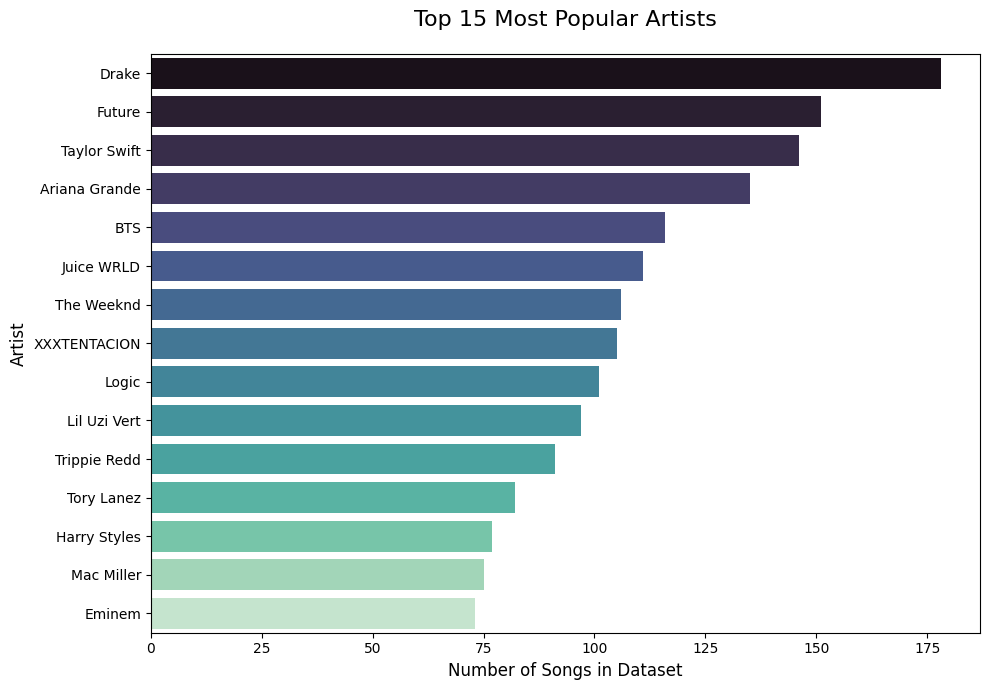

In [13]:
# Plot top 15 most popular Artists by song count
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each artist
artist_counts = (
    filtered_df.groupBy("Artist")
    .count()
    .orderBy(col("count").desc())  # Sort in descending order
    .limit(15)  # Select the top 15 artists
    .toPandas()  # Convert to Pandas for visualization
)

# Plot the data
plt.figure(figsize=(10, 7))
sns.barplot(data=artist_counts, x="count", y="Artist", hue="Artist", legend = False, palette='mako')

# Customize the plot
plt.title("Top 15 Most Popular Artists", fontsize=16, pad=20)
plt.xlabel("Number of Songs in Dataset", fontsize=12)
plt.ylabel("Artist", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

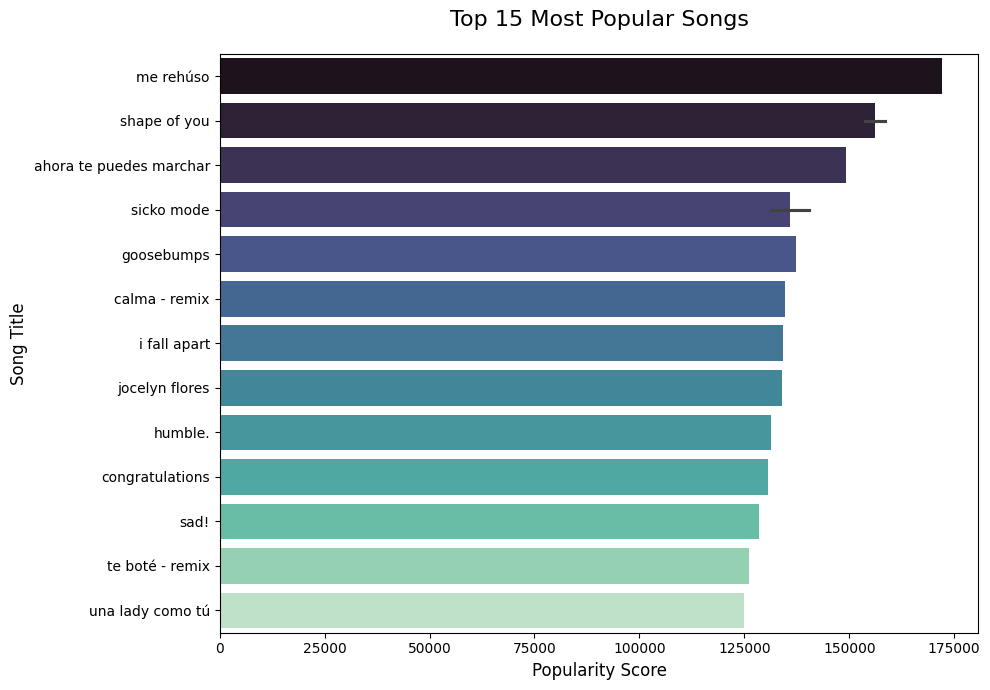

In [14]:
# Plot top 15 most popular songs by Popularity
popular_songs = (
    filtered_df.select("Title", "Popularity")
    .orderBy(col("Popularity").desc())
    .limit(15)
    .toPandas()
)

# Plot the data
plt.figure(figsize=(10, 7))
sns.barplot(data=popular_songs, x="Popularity", y="Title", hue="Title", legend = False, palette='mako')

# Customize the plot
plt.title("Top 15 Most Popular Songs", fontsize=16, pad=20)
plt.xlabel("Popularity Score", fontsize=12)
plt.ylabel("Song Title", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

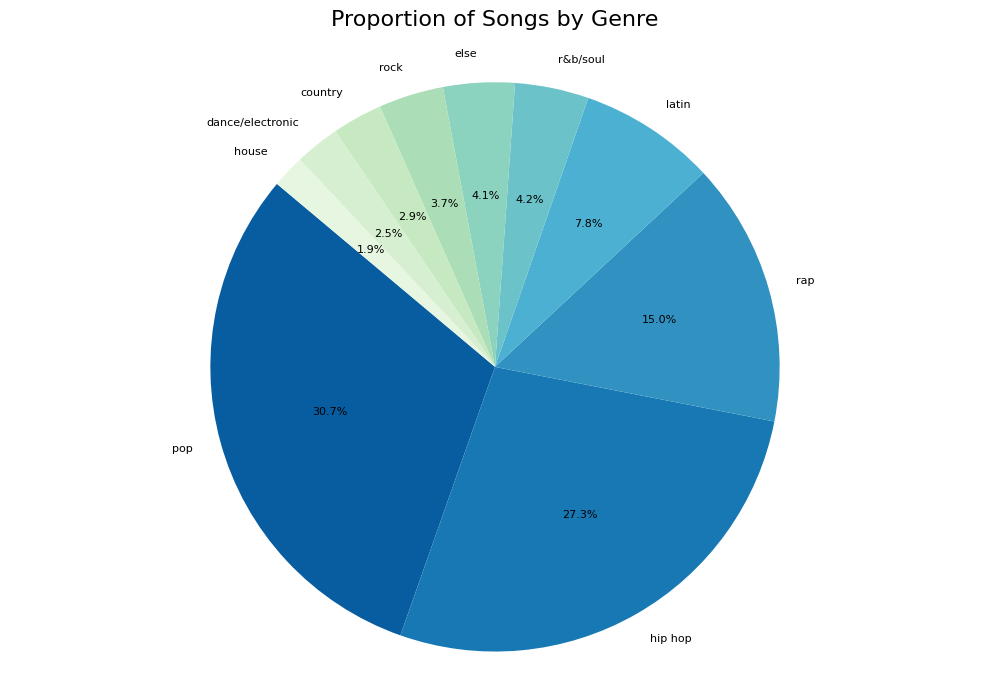

In [15]:
# Plot top 10 Most Frequent Genres
#  Group data by Genre and count the number of songs per genre
genre_counts = (
    filtered_df.groupBy("Genre_new")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
    .toPandas()
)

# Generate colors
colors = sns.color_palette("GnBu_r", len(genre_counts)).as_hex()

# Plot the pie chart
plt.figure(figsize=(10, 7))
plt.pie(
    genre_counts["count"],
    labels=genre_counts["Genre_new"],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
     textprops={'fontsize': 8}
)

# Customize the plot
plt.title("Proportion of Songs by Genre", pad=20, fontsize=16)
plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular

# Show the plot
plt.tight_layout()
plt.show()

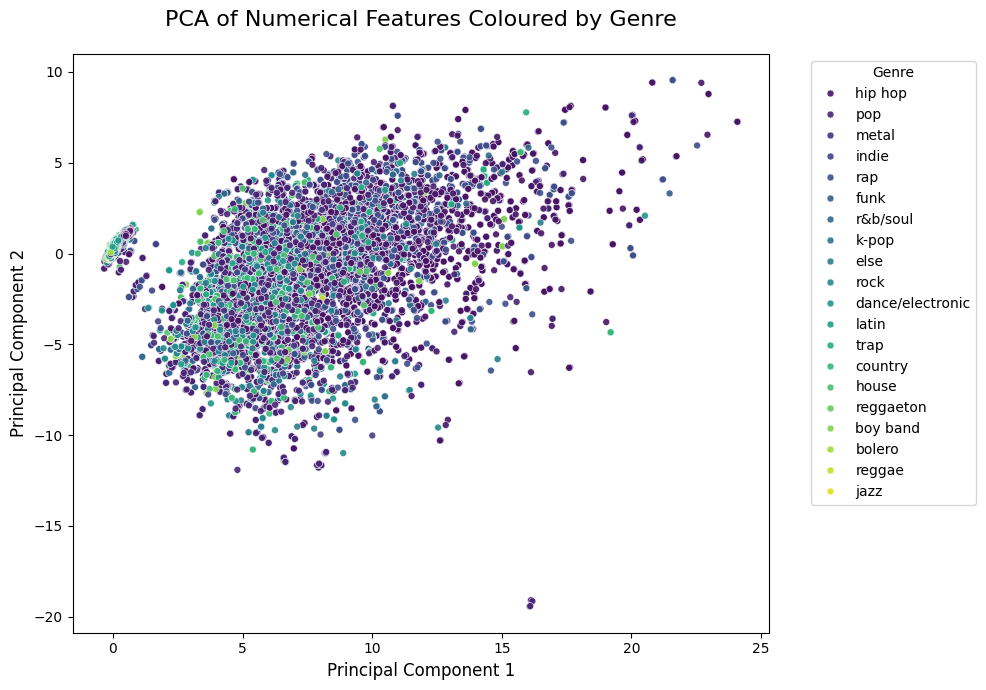

In [16]:
# Perform PCA analysis to visualize the high-dimensional data
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

# Remove rows with nulls in numerical features (as required by VectorAssembler)
pca_ready_df = filtered_df.dropna(subset=numerical_features)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features_assembled")
df_with_features = assembler.transform(pca_ready_df)

# Scale the features
scaler = StandardScaler(inputCol="features_assembled", outputCol="features_scaled")
scaler_model = scaler.fit(df_with_features)
df_scaled = scaler_model.transform(df_with_features)

# Apply PCA to the scaled features
pca = PCA(k=2, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
pca_result = pca_model.transform(df_scaled)

# Convert PCA result to Pandas for visualization
pandas_df = pca_result.select("pca_features", "Genre_new", 'positive', 'Explicit_true').toPandas()
pandas_df[['PCA1', 'PCA2']] = pandas_df['pca_features'].apply(lambda x: list(x)).to_list()

# Create a scatter plot for PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Genre_new",  # Color by Genre_new
    data=pandas_df,
    palette="viridis",
    s=25,  # Point size
    alpha=0.9  # Transparency
)

# Add labels and title
plt.title("PCA of Numerical Features Coloured by Genre", fontsize=16, pad=20)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)

# Add legend and layout adjustments
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

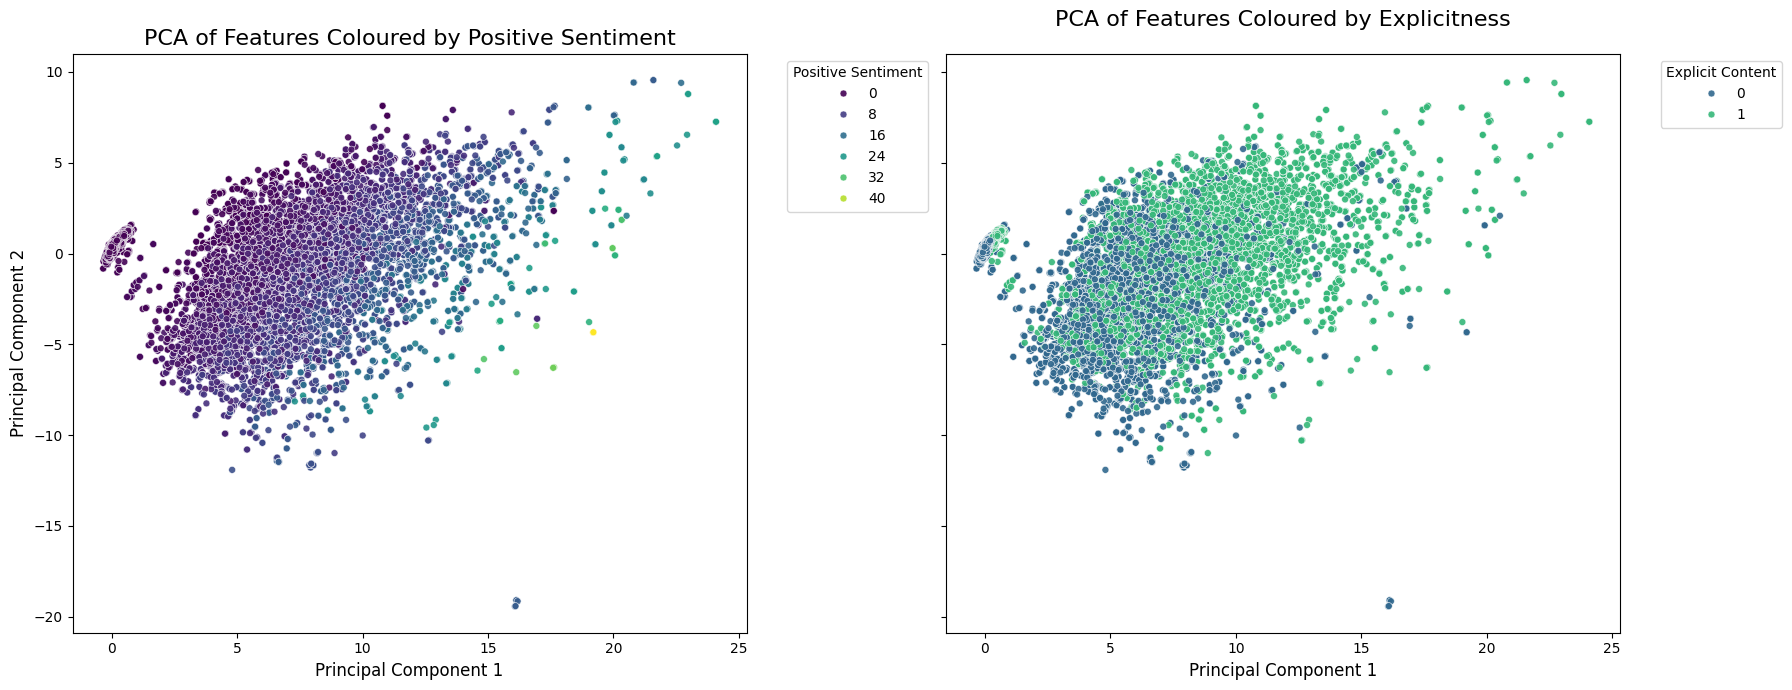

In [17]:
# Create 2 more subplots for PCA results with different hues
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# PCA with hue = 'positive'
sns.scatterplot(
    x="PCA1", y="PCA2", hue="positive",
    data=pandas_df, palette="viridis", s=25, alpha=0.9, ax=axes[0]
)
axes[0].set_title("PCA of Features Coloured by Positive Sentiment", fontsize=16)
axes[0].set_xlabel("Principal Component 1", fontsize=12)
axes[0].set_ylabel("Principal Component 2", fontsize=12)
axes[0].legend(title="Positive Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: PCA with hue = 'Explicit_true'
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Explicit_true",
    data=pandas_df, palette="viridis", s=25, alpha=0.9, ax=axes[1]
)
axes[1].set_title("PCA of Features Coloured by Explicitness", fontsize=16, pad=20)
axes[1].set_xlabel("Principal Component 1", fontsize=12)
axes[1].legend(title="Explicit Content", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

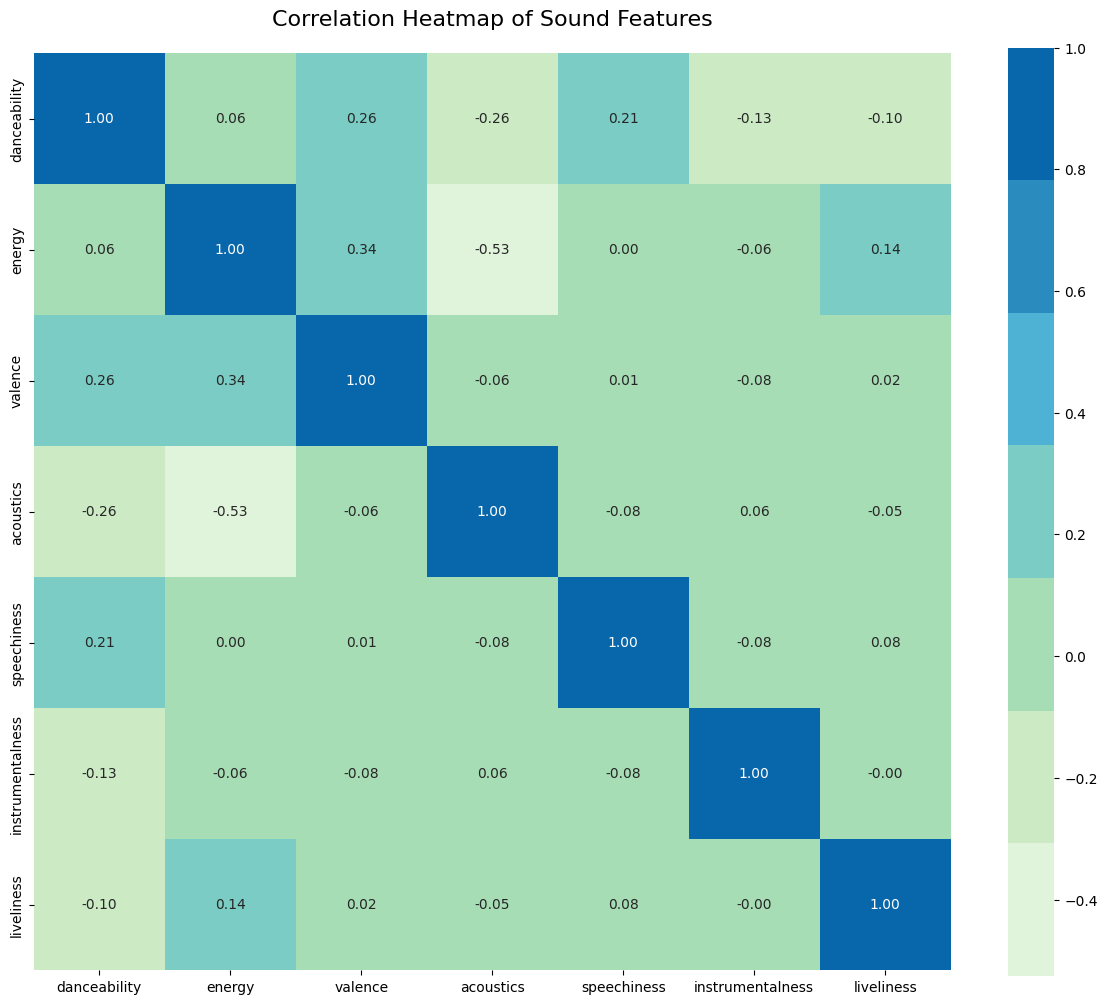

In [18]:
# Plot a heatmap showing correlation of sound features

# Select sound features to analyze
sound_features = ['danceability', 'energy', 'valence', 'acoustics', 'speechiness', 'instrumentalness', 'liveliness']

# Create a subset DataFrame
subset_df = filtered_df.select(*sound_features)

# Convert to Pandas DataFrame for correlation computation
pandas_df = subset_df.toPandas()

# Compute the correlation matrix
correlation_matrix = pandas_df.corr(method='pearson')

# Generate colors
colors = sns.color_palette("GnBu", len(sound_features))

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=colors, cbar=True, square=True)

# Customize the plot
plt.title("Correlation Heatmap of Sound Features", fontsize=16, pad=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

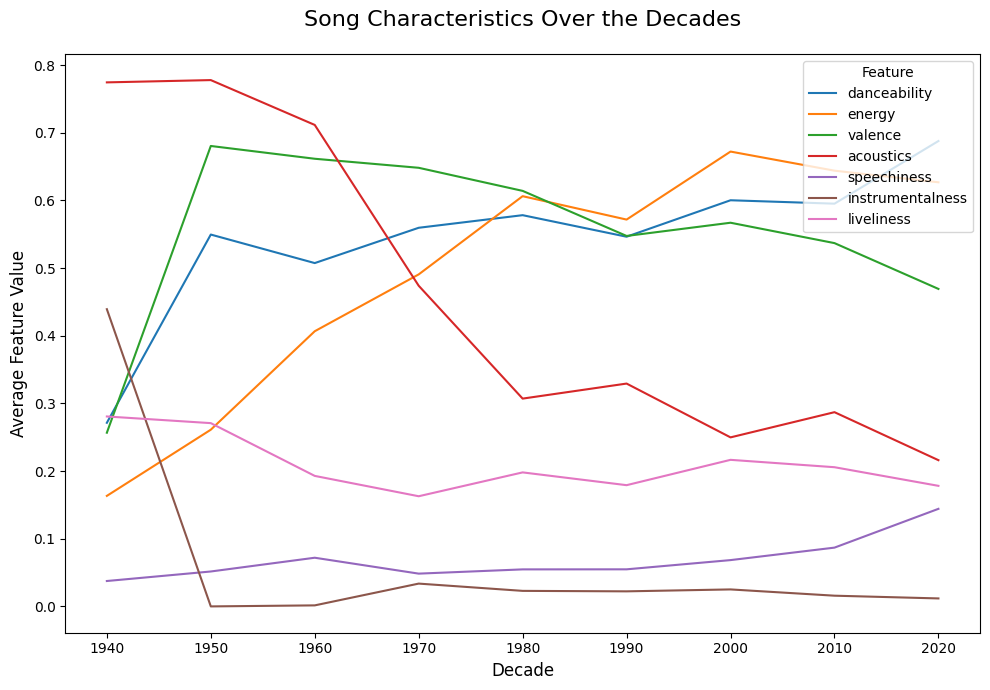

In [19]:
# Plot sound features over the decades
from pyspark.sql import functions as func

# Group by Decade and calculate the mean for each feature
aggregated_df = (filtered_df
                 .withColumn("Decade", func.round(func.year(func.to_date("Release_Date", "yyyy-MM-dd")), -1))
                 .groupBy("Decade")
                 .agg(
                     *[func.avg(feature).alias(feature) for feature in sound_features]
                 )
                 .orderBy("Decade")
                 .toPandas()
                 .dropna()  # Drop rows with missing values
                )

# Melt data for seaborn plotting
melted_df = aggregated_df.melt(id_vars="Decade",
                                value_vars=sound_features,
                                var_name="Feature",
                                value_name="Value")

# Plot using Seaborn
plt.figure(figsize=(10, 7))
sns.lineplot(data=melted_df, x="Decade", y="Value", hue="Feature")

# Customize plot
plt.title("Song Characteristics Over the Decades", fontsize=16, pad=20)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average Feature Value", fontsize=12)
plt.legend(title="Feature", loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()

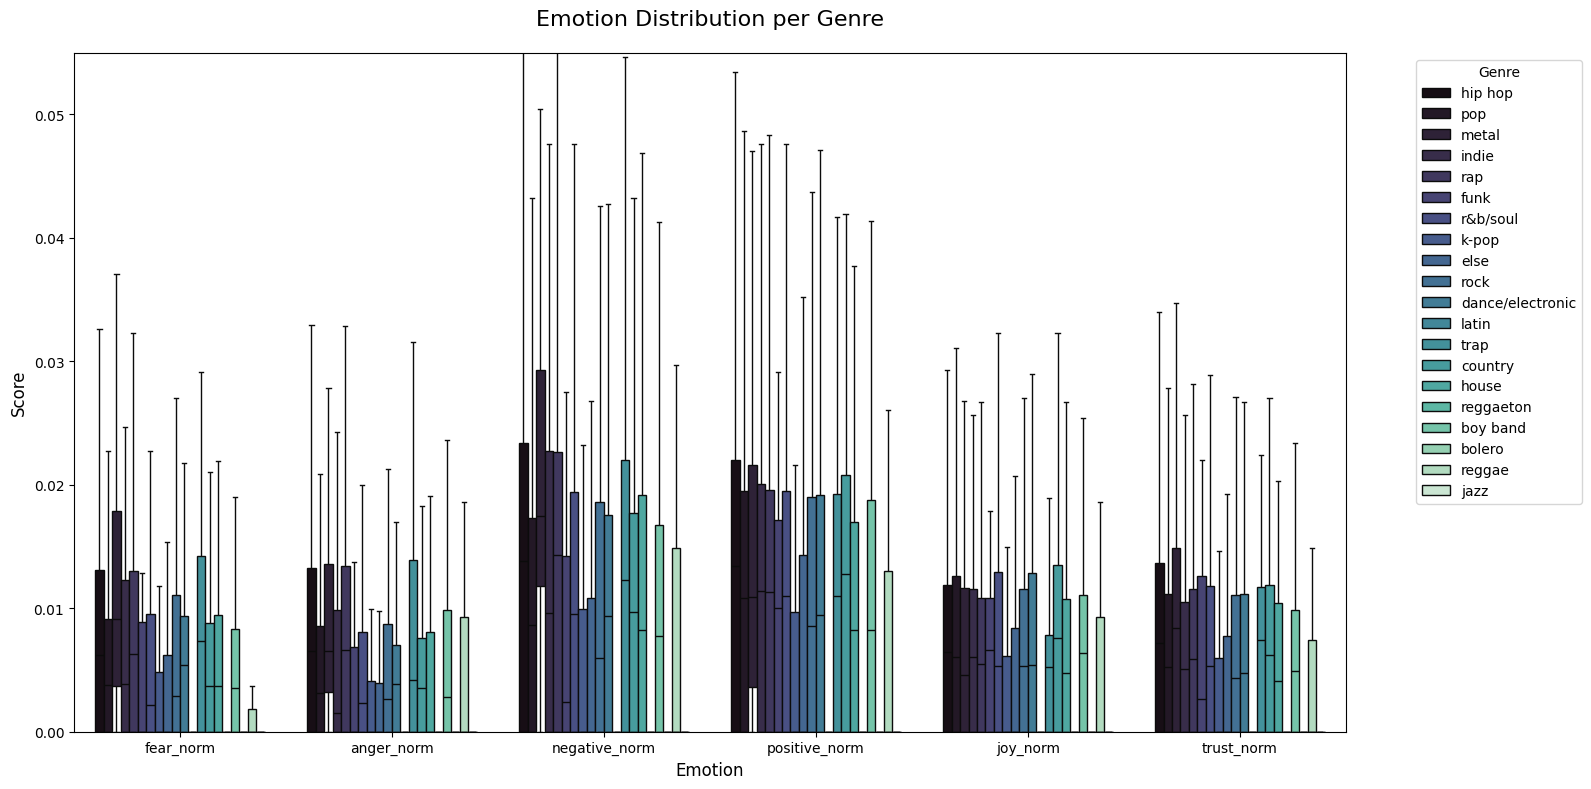

In [20]:
# Plot emotion distribution per Genre
sentiment_scores = ["fear_norm", "anger_norm", "negative_norm", "positive_norm", "joy_norm", "trust_norm"]

# Select relevant columns (sentiment scores + Genre)
emotion_df = filtered_df.dropna(subset=numerical_features).select(sentiment_scores + ["Genre_new"]).toPandas()

# Melt the data for easier plotting
melted_df = emotion_df.melt(
    id_vars="Genre_new",
    value_vars=sentiment_scores,
    var_name="Emotion",
    value_name="Score"
)

# Plot the data
plt.figure(figsize=(16, 8))
sns.boxplot(data=melted_df, x="Emotion", y="Score", hue="Genre_new", palette = 'mako', showfliers=False)

# Customize the plot
plt.title("Emotion Distribution per Genre", fontsize=16, pad=20)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 0.055)  # Adjust y-axis to match the range of norms
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.tight_layout()

# Show the plot
plt.show()

# Data Filtering

As mentioned previously, the dimensionality of this dataset is quite high, which may cause issues for our popularity predictor models. We already reduced this dimensionality in an earlier step by confinihg the data to songs that charted in North America. We can reduce it further by removing columns with low correlation to the target vector. To this end, we can use the filter method, wherein we calculate the linear correlation between each feature and the target variable and remove low scores up to some cutoff (in this case we will take the top 50 features). This should reduce dimensionality considerably while leaving us with the most important features.

Additionally, some columns still need to be removed as they were unable to be casted and are not feasible to encode, or were pre-encoded and are now redundant. We also need to remove the old `Popularity` feature as we replaced it with `PopularityCategory`. This is done to avoid causing information leakage.

In [21]:
# Removing string data, leaving only numeric + target vector
print("Features before filtering:")
print(filtered_df.show(10))

# NOTE: All of these string columns are either not useful or are already encoded.
#       We are not losing out on any useful data in this step.
string_columns = [col for col, dtype in filtered_df.dtypes if dtype == 'string' and col != "PopularityCategory"]
reduced_df = filtered_df.drop(*string_columns)

print("Features after string data removal:")
print(reduced_df.show(10))


Features before filtering:
+--------+--------------------+-----------------+-----------------+--------------------+------------+-----------------+----------------+--------+--------------------+------------+------------+---------------+------------------+------------------+---+-------------------+----+-----------+-------------------+----------------+----------+-------+-----------------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+---+-------+--------+-----+--------+--------+-------+-------------------+-------------------+------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------

In [22]:
# Using filter method to perform feature reduction (keeping top 50 features)
from pyspark.sql.functions import corr
from pyspark.sql.types import StringType
import math
correlations = []

for column in reduced_df.columns:
  if column != 'PopularityCategory' and column != 'Popularity':
    correlation = reduced_df.select(corr(column, 'Popularity')).collect()[0][0]
    if correlation != None and not math.isnan(correlation):
     correlations.append((column, abs(correlation)))

correlations.sort(key=lambda x: x[1], reverse=True)
# Take only the top 50 results
correlations = correlations[:50]
for tup in correlations:
  print(tup)

('Top10_dummy', 0.5206764298687954)
('Top50_dummy', 0.435147693275788)
('Popu_max', 0.4342590783014516)
('latin', 0.15302984544906248)
('Mexico', 0.15248310175302035)
('Artist_followers', 0.1113679727377842)
('danceability', 0.10983334236371024)
('USA', 0.08631491075260406)
('loudness', 0.08120823241236935)
('hip hop', 0.08008699966903067)
('Track_number', 0.07562097830472389)
('single', 0.07157821842073613)
('valence', 0.0714495025049164)
('Tracks_in_album', 0.06598941573629269)
('album31', 0.06584212337904699)
('Explore', 0.0589483170788051)
('Days_since_release', 0.04833998566361901)
('negative_norm', 0.0454519560805591)
('Explicit_false', 0.04494447601958983)
('Explicit_true', 0.044944476019589036)
('positive_norm', 0.04447465555538783)
('fear_norm', 0.04444714017270005)
('trust_norm', 0.04289296806103092)
('sadness_norm', 0.042795051344895745)
('anticipation_norm', 0.04185738971599622)
('k-pop', 0.04167745980047169)
('reggaeton', 0.04015435383666059)
('metal', 0.038917007865403724

In [23]:
# Now we can remove 'Popularity' to avoid information leakage
reduced_df_2 = reduced_df.drop("Popularity")

# Remove all features that didn't make it into top 50
top50_cols = [tup[0] for tup in correlations]
reduced_df_2 = reduced_df_2.select(*top50_cols, "PopularityCategory")
print(reduced_df_2.show(10))

+-----------+-----------+--------+-----+------+----------------+------------------+---+-------------------+-------+------------+------+-------+---------------+-------+-------+------------------+------------------+--------------+-------------+-------------------+-------------------+-------------------+------------------+-------------------+-----+---------+-----+-----------+-------------------+----------+---+-------------------+----+----+------+---+------------+----------------+-----+---------+----+------------+-------+--------+--------+---------+-----------------+------------------+--------+------------------+
|Top10_dummy|Top50_dummy|Popu_max|latin|Mexico|Artist_followers|      danceability|USA|           loudness|hip hop|Track_number|single|valence|Tracks_in_album|album31|Explore|Days_since_release|     negative_norm|Explicit_false|Explicit_true|      positive_norm|          fear_norm|         trust_norm|      sadness_norm|  anticipation_norm|k-pop|reggaeton|metal|speechiness|      su

# Popularity Predictor

We will be evaluating three machine learning models for building a popularity predictor:
- Random Forest
- Decision Tree
- Logistic Regression

First, we used the features selected in the previous step to assemble a feature vector.

In [24]:
from ast import mod

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer

# Assemble filtered features
indexer = StringIndexer(inputCol="PopularityCategory", outputCol="label")
model1_df = indexer.fit(reduced_df_2).transform(reduced_df_2)

for fname in top50_cols:
  model1_df = model1_df.withColumn(fname, col(fname).cast("double"))

model1_df = model1_df.dropna()

assembler = VectorAssembler(inputCols=top50_cols, outputCol="features", handleInvalid = "keep")
model1_df = assembler.transform(model1_df).select("features", "label")

model1_df.select("features").show(truncate=False)

model1_df = model1_df.repartition(4)

# Split data into train and test, stratify on label
fractions = model1_df.select("label").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
train_df = model1_df.sampleBy("label", fractions, seed=42)
test_df = model1_df.subtract(train_df)

# Split data into train and test sets
#train_df, test_df = model1_df.randomSplit([0.8, 0.2], seed=42, )

# Initialize the classifiers
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", seed=42)
lr_classifier = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

After that, we set up different parameter grids and cross-validator for each model to optimize their performance.

In [25]:
# Create parameter grids for each classifier
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf_classifier.numTrees, [50, 100])
                .addGrid(rf_classifier.maxDepth, [5, 10])
                .build())

dt_paramGrid = (ParamGridBuilder()
                .addGrid(dt_classifier.maxDepth, [5, 10, 15])
                .addGrid(dt_classifier.minInstancesPerNode, [1, 2, 4])
                .build())

lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr_classifier.regParam, [0.01, 0.1, 1.0])
                .addGrid(lr_classifier.elasticNetParam, [0.0, 0.5, 1.0])
                .build())

In [26]:
# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Set up CrossValidators for each model
rf_cv = CrossValidator(estimator=rf_classifier,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=evaluator,
                       numFolds=3,
                       parallelism=2)

dt_cv = CrossValidator(estimator=dt_classifier,
                       estimatorParamMaps=dt_paramGrid,
                       evaluator=evaluator,
                       numFolds=3,
                       parallelism=2)

lr_cv = CrossValidator(estimator=lr_classifier,
                       estimatorParamMaps=lr_paramGrid,
                       evaluator=evaluator,
                       numFolds=3,
                       parallelism=2)

Then we fit the models, make predictions, and evaluate the performance of each model.

In [27]:
# Fit the models. Note: this could take several minutes
print("Fitting Random Forest model...")
rf_model = rf_cv.fit(train_df)
print("Fitting Decision Tree model...")
dt_model = dt_cv.fit(train_df)
print("Fitting Logistic Regression model...")
lr_model = lr_cv.fit(train_df)

Fitting Random Forest model...
Fitting Decision Tree model...
Fitting Logistic Regression model...


In [28]:
# Make predictions on the test set
rf_predictions = rf_model.transform(test_df)
dt_predictions = dt_model.transform(test_df)
lr_predictions = lr_model.transform(test_df)

# Evaluate the models
rf_accuracy = evaluator.evaluate(rf_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")

Random Forest Accuracy: 0.8491927172792855
Decision Tree Accuracy: 0.8282377189969082
Logistic Regression Accuracy: 0.822054276880797


In [29]:
# Determine the best model
accuracies = {'Random Forest': rf_accuracy, 'Decision Tree': dt_accuracy, 'Logistic Regression': lr_accuracy}
best_model_name = max(accuracies, key=accuracies.get)
print(f"The best model is: {best_model_name} with an accuracy of {accuracies[best_model_name]}")

# Access the best model and its parameters
if best_model_name == 'Random Forest':
    best_model = rf_model.bestModel
    best_params = rf_model.bestModel.extractParamMap()
elif best_model_name == 'Decision Tree':
    best_model = dt_model.bestModel
    best_params = dt_model.bestModel.extractParamMap()
else:
    best_model = lr_model.bestModel
    best_params = lr_model.bestModel.extractParamMap()

print("Best Model Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

The best model is: Random Forest with an accuracy of 0.8491927172792855
Best Model Parameters:
RandomForestClassifier_5e7d61b3f69e__bootstrap: True
RandomForestClassifier_5e7d61b3f69e__cacheNodeIds: False
RandomForestClassifier_5e7d61b3f69e__checkpointInterval: 10
RandomForestClassifier_5e7d61b3f69e__featureSubsetStrategy: auto
RandomForestClassifier_5e7d61b3f69e__featuresCol: features
RandomForestClassifier_5e7d61b3f69e__impurity: gini
RandomForestClassifier_5e7d61b3f69e__labelCol: label
RandomForestClassifier_5e7d61b3f69e__leafCol: 
RandomForestClassifier_5e7d61b3f69e__maxBins: 32
RandomForestClassifier_5e7d61b3f69e__maxDepth: 10
RandomForestClassifier_5e7d61b3f69e__maxMemoryInMB: 256
RandomForestClassifier_5e7d61b3f69e__minInfoGain: 0.0
RandomForestClassifier_5e7d61b3f69e__minInstancesPerNode: 1
RandomForestClassifier_5e7d61b3f69e__minWeightFractionPerNode: 0.0
RandomForestClassifier_5e7d61b3f69e__numTrees: 50
RandomForestClassifier_5e7d61b3f69e__predictionCol: prediction
RandomFore

# Clustering

### Feature Preparation for Clustering

To cluster the music dataset effectively, the features were prepared as follows:

1. **Feature Selection**:
   A set of key musical attributes was chosen as the features for clustering:
   - `danceability`
   - `energy`
   - `valence`
   - `tempo`
   - `loudness`
   - `speechiness`
   - `acoustics`
   - `instrumentalness`
   - `liveliness`

2. **Feature Vector Assembly**:
   Using PySpark's `VectorAssembler`, these individual features were combined into a single vector under the column `features`. This format is essential for PySpark's machine learning pipeline.

In [30]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import numpy as np

# Select feature columns for clustering
feature_columns = ["danceability", "energy", "valence", "tempo", "loudness", "speechiness", "acoustics", "instrumentalness", "liveliness"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(df_for_clustering)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

### Determining the Optimal Number of Clusters (k)

To find the best number of clusters for the music dataset, the **Elbow Method** was applied. This method evaluates the sum of squared errors (WSSSE) for different values of `k` and identifies an "elbow point" where the rate of improvement slows down.

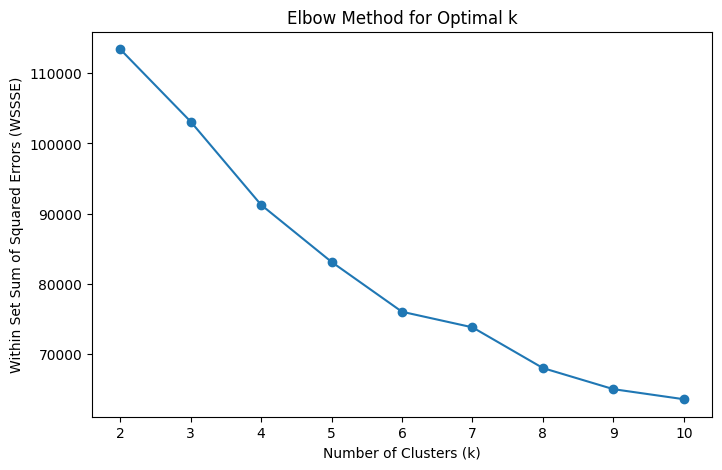

In [31]:
import matplotlib.pyplot as plt

# Initialize variables
wssse_values = []
k_values = range(2, 11)  # Test k from 2 to 10

for k in k_values:
    # Fit K-Means with k clusters
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=1)
    kmeans_model = kmeans.fit(scaled_df)

    # Calculate WSSSE
    centroids = kmeans_model.clusterCenters()
    broadcast_centroids = spark.sparkContext.broadcast(centroids)

    @udf(DoubleType())
    def compute_squared_distance(point, cluster_id):
        centroid = broadcast_centroids.value[cluster_id]
        return float(np.sum((np.array(point) - np.array(centroid)) ** 2))

    clusters_df = kmeans_model.transform(scaled_df)
    clusters_df = clusters_df.withColumn(
        "squared_distance",
        compute_squared_distance("scaled_features", "prediction")
    )
    wssse = clusters_df.select("squared_distance").rdd.map(lambda row: row[0]).sum()
    wssse_values.append(wssse)

# Plot WSSSE vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, wssse_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

Based on the above plot, it appears that the elbow is located at either k = 6, or k = 8.

### Evaluating Cluster Quality with Silhouette Scores

The **Silhouette Score** was used to evaluate the quality of clustering for different numbers of clusters (`k`), and to confirm the optimal k. This metric provides insight into how well-separated the clusters are and how close points are to their assigned cluster versus others.

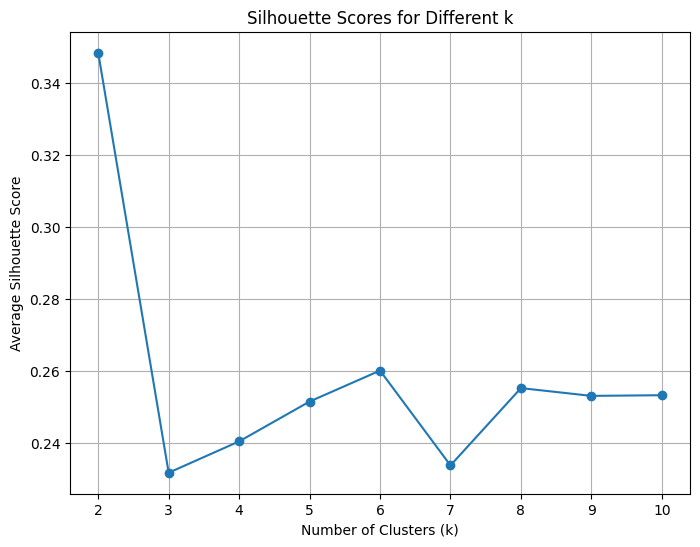

In [32]:
import matplotlib.pyplot as plt

# Initialize an empty list to store silhouette scores
k_values = list(range(2, 11))  # Testing k from 2 to 10
silhouette_scores = []

# Loop through different k values
for k in k_values:
    # Fit KMeans model with current k
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=1)
    kmeans_model = kmeans.fit(scaled_df)

    # Assign predictions to the data
    clusters_df = kmeans_model.transform(scaled_df)

    # Broadcast cluster centers
    cluster_centers = kmeans_model.clusterCenters()
    broadcast_centers = spark.sparkContext.broadcast(cluster_centers)

    # UDFs to calculate intra-cluster and nearest-cluster distances
    @udf(DoubleType())
    def compute_distance(point, cluster_id):
        point_array = np.array(point)
        center = np.array(broadcast_centers.value[cluster_id])
        return float(np.linalg.norm(point_array - center))

    @udf(DoubleType())
    def nearest_cluster_distance(point, cluster_id):
        point_array = np.array(point)
        other_centers = [np.array(c) for i, c in enumerate(broadcast_centers.value) if i != cluster_id]
        distances = [np.linalg.norm(point_array - center) for center in other_centers]
        return float(min(distances))

    clusters_df = clusters_df.withColumn(
        "intra_cluster_distance", compute_distance("scaled_features", "prediction")
    ).withColumn(
        "nearest_cluster_distance", nearest_cluster_distance("scaled_features", "prediction")
    )

    # Calculate silhouette score for each point
    @udf(DoubleType())
    def silhouette_score(a, b):
        if a == b:
            return 0.0
        return (b - a) / max(a, b)

    clusters_df = clusters_df.withColumn(
        "silhouette", silhouette_score(col("intra_cluster_distance"), col("nearest_cluster_distance"))
    )

    # Compute the average silhouette score for current k
    silhouette_avg = clusters_df.select("silhouette").rdd.map(lambda row: row[0]).mean()
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

### Applying K-Means Clustering with k = 6

The K-Means algorithm was applied to the music dataset, `k=6` was chosen for clustering. While `k=2` has a higher silhouette score, we are more interested in examinining clusters that may correlate with genres. In the case of genres, we expect `k=6` to potentially be a better match to potentially group similar genres.

In [33]:
# Apply K-Means clustering
kmeans = KMeans(featuresCol="scaled_features", k=6, seed=1)  # k=6
kmeans_model = kmeans.fit(scaled_df)

# Make predictions
clusters_df = kmeans_model.transform(scaled_df)

# Show cluster assignments
clusters_df.select("scaled_features", "prediction").show(truncate=False)

# Function to calculate squared Euclidean distance
def squared_distance(point, centroid):
    return float(np.sum((np.array(point) - np.array(centroid)) ** 2))

# Get cluster centers as a broadcast variable
centroids = kmeans_model.clusterCenters()
broadcast_centroids = spark.sparkContext.broadcast(centroids)

# UDF to compute squared distance
@udf(DoubleType())
def compute_squared_distance(point, cluster_id):
    centroid = broadcast_centroids.value[cluster_id]
    return squared_distance(point, centroid)

# Add a column with squared distances
clusters_df = clusters_df.withColumn(
    "squared_distance",
    compute_squared_distance("scaled_features", "prediction")
)

# Analyze clusters
clusters_df.groupBy("prediction").count().show()

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|scaled_features                                                                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[0.6082412444183395,0.5004246831053625,1.0705833307953736,1.6565630391109145,0.8068833177330198,1.596863031904545,0.39191374549209784,-0.1559310921965085,-0.8123924845316037]           |2         |
|[0.6082412444183395,0.5004246831053625,1.0705833307953736,1.6565630391109145,0.8068833177330198,1.596863031904545,0.39191374549209784,-0.1559310921965085,-0.8123924845316037]           |2         |
|[-0.

### Analyzing Genre Distribution Across Clusters

To understand the relationship between music genres and clusters, a detailed analysis was performed to group, count, and visualize genre occurrences within clusters.

In [34]:
# Group by cluster (prediction) and genre, then count occurrences
genre_distribution = clusters_df.groupBy("prediction", "genre_new").count()


In [35]:
from pyspark.sql.functions import col, sum as _sum

# Calculate total count of each genre across all clusters
genre_totals = genre_distribution.groupBy("genre_new").agg(_sum("count").alias("total_count"))

# Filter genres with at least 30 entries
popular_genres = genre_totals.filter(col("total_count") >= 100).select("genre_new").rdd.flatMap(lambda x: x).collect()

# Pivot the table only for popular genres
filtered_pivot = genre_distribution.filter(col("genre_new").isin(popular_genres)) \
                                   .groupBy("prediction").pivot("genre_new").sum("count")

# Replace nulls with 0 for easier analysis
filtered_pivot = filtered_pivot.fillna(0)

# Show the resulting table
filtered_pivot.show(truncate=False)

+----------+------+--------+-------+----------------+----+-------+-----+-----+-----+-----+-----+----+--------+---+----+----+
|prediction|bolero|boy band|country|dance/electronic|else|hip hop|house|indie|k-pop|latin|metal|pop |r&b/soul|rap|rock|trap|
+----------+------+--------+-------+----------------+----+-------+-----+-----+-----+-----+-----+----+--------+---+----+----+
|1         |48    |13      |56     |9               |151 |232    |3    |49   |17   |102  |2    |811 |177     |145|62  |10  |
|3         |0     |0       |0      |6               |22  |25     |4    |12   |1    |17   |25   |27  |31      |11 |13  |0   |
|5         |21    |96      |187    |131             |199 |633    |119  |40   |144  |641  |41   |1587|85      |389|198 |29  |
|4         |8     |22      |28     |31              |37  |432    |24   |10   |19   |89   |23   |308 |33      |140|53  |12  |
|2         |0     |22      |0      |14              |51  |1613   |2    |11   |10   |84   |0    |329 |71      |809|19  |44  |


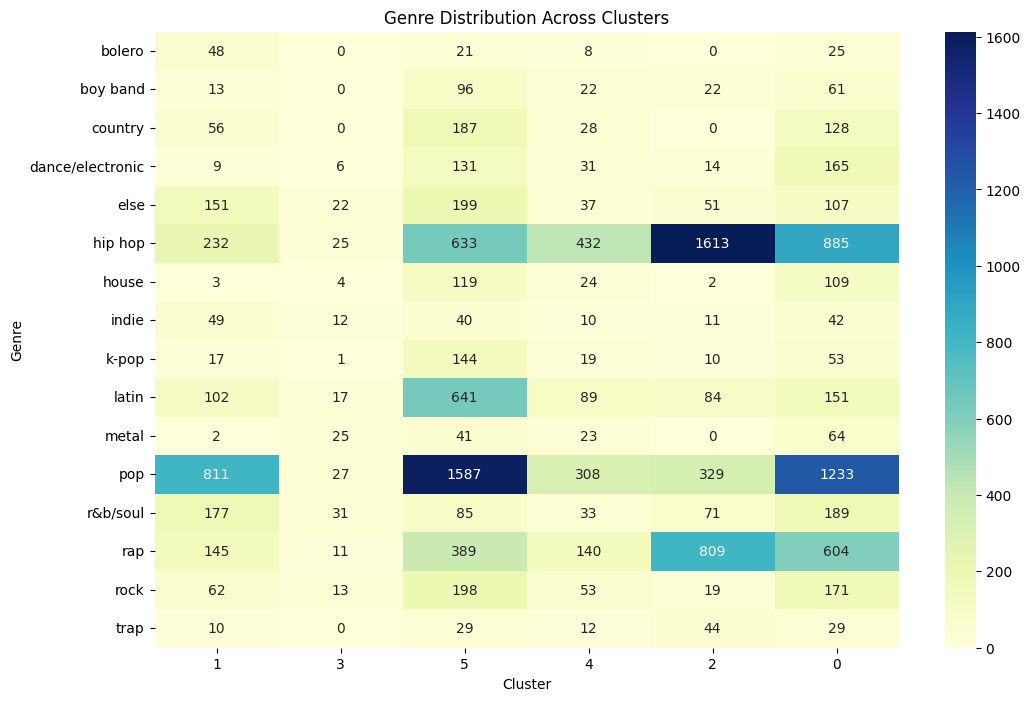

In [36]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for heatmap visualization
genre_counts_pd = filtered_pivot.toPandas()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(genre_counts_pd.set_index("prediction").T, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Genre Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Genre")
plt.show()

As shown in the above heatmap, it does appear that each genre is primarily contained within a couple of clusters. While not a one to one relationship, there does appear to be some inherent grouping across genres.

### Visualizing Clusters: Energy vs Other Features

To explore the relationships between clusters and features, scatter plots were created comparing the target feature **energy** against other features. Each data point was colored based on its cluster assignment. We kept energy as the constant y-axis since it appeared to do the best job of separating clusters.

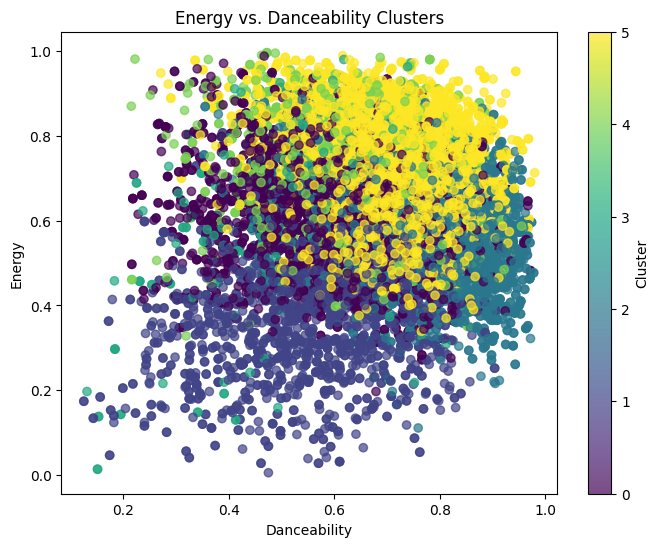

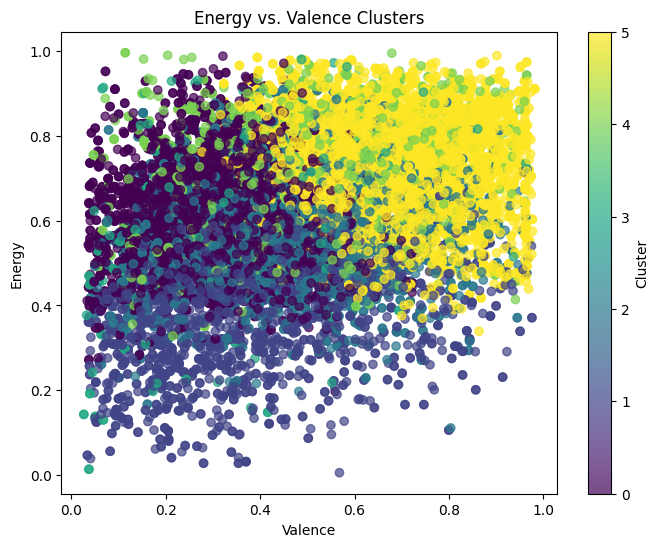

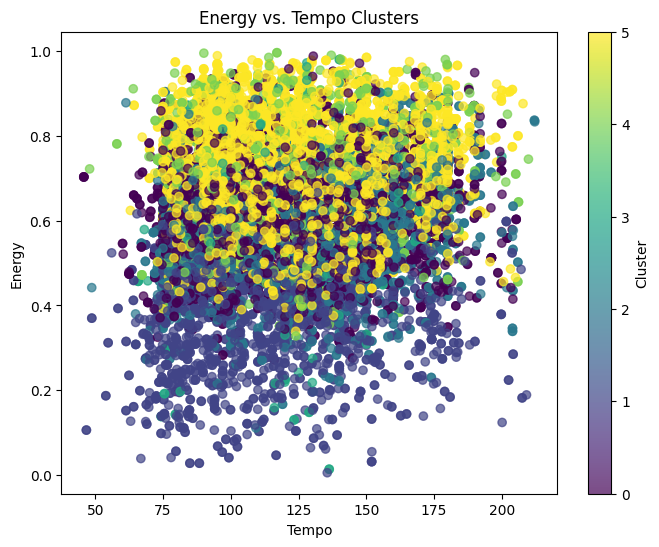

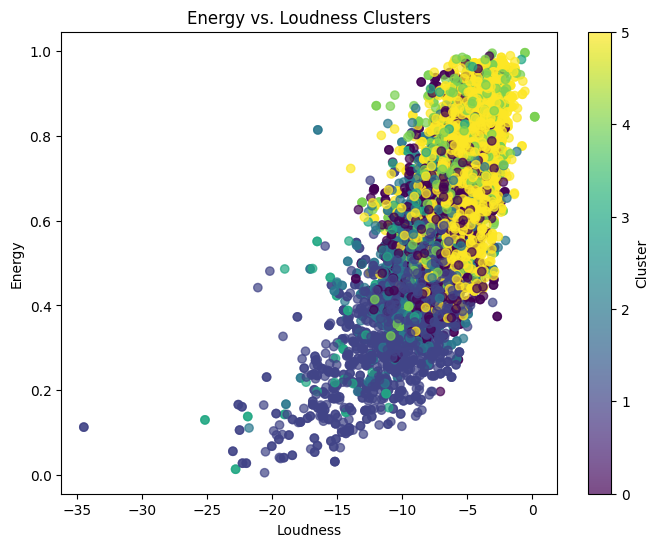

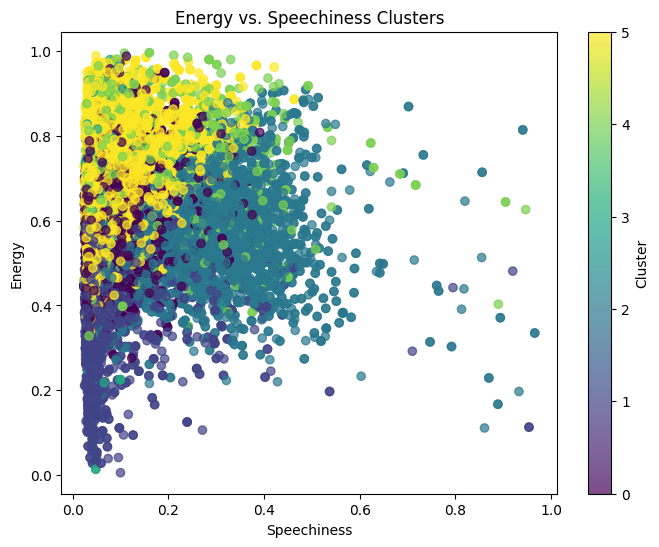

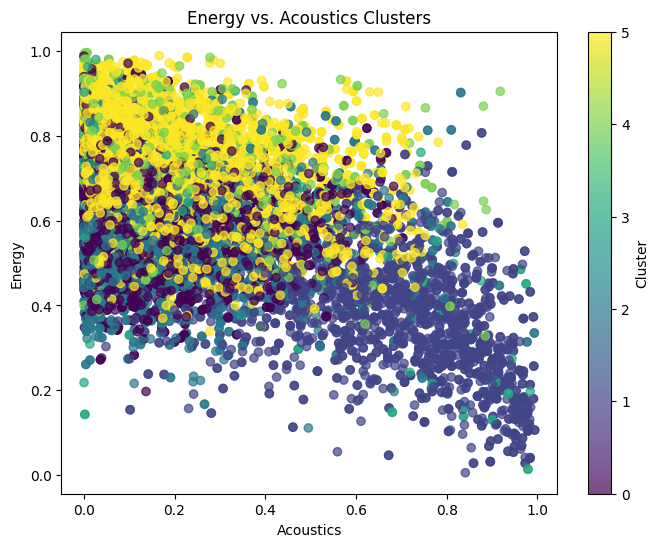

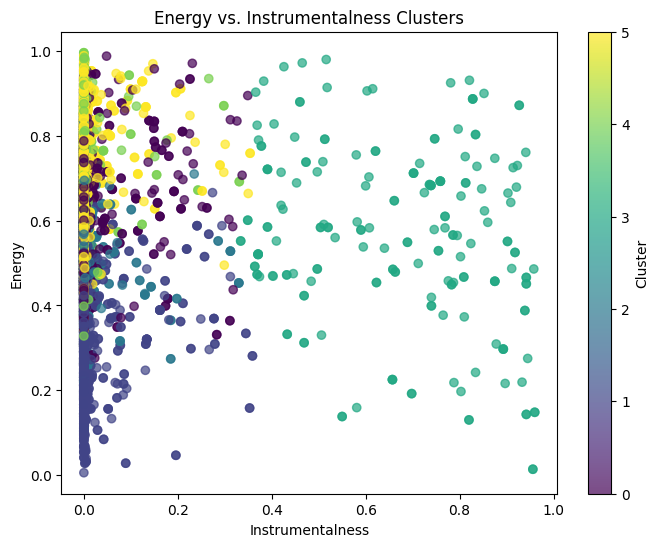

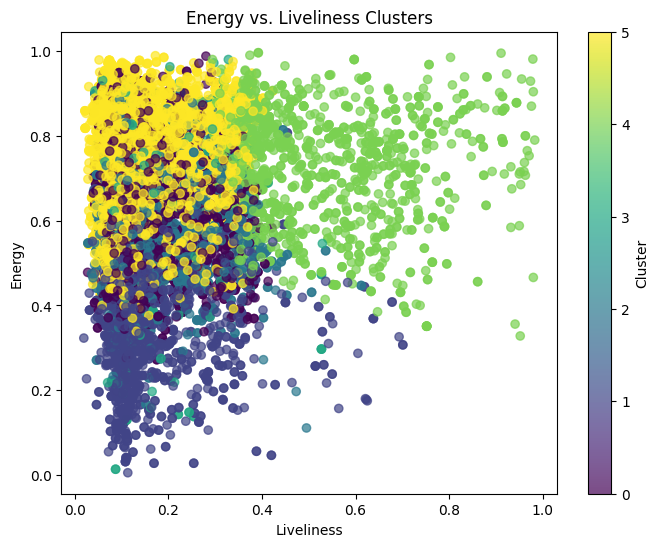

In [37]:
import matplotlib.pyplot as plt

# Convert the clusters dataframe to Pandas
scatter_df = clusters_df.select(feature_columns + ["prediction"]).toPandas()

# Define the target feature ("energy") and the other features to plot against
target_feature = "energy"
features_to_compare = [col for col in feature_columns if col != target_feature]

# Create scatter plots for energy vs. each of the other features
for feature in features_to_compare:
    plt.figure(figsize=(8, 6))
    plt.scatter(scatter_df[feature], scatter_df[target_feature], c=scatter_df["prediction"], cmap="viridis", alpha=0.7)
    plt.xlabel(feature.capitalize())
    plt.ylabel(target_feature.capitalize())
    plt.title(f"Energy vs. {feature.capitalize()} Clusters")
    plt.colorbar(label="Cluster")
    plt.show()

By examining the above plots, we can see which features are the most important to the clustering. Plots that clearly display the different clusters will have features that did a better job of separating the data.

# KNN Music Recommender CLI

### Song Recommendation System Based on Euclidean Distance

In this section, we apply a song recommendation system using the K-NN model on a set of audio features. We also included CLIs for searching the song database and generating recommendations for a user-specified song.

The K-NN model returns the K closest data samples (the neighbors) to any given sample. We were curious if the closest samples in our selected feature space could function as a song recommendation system.

In [38]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
from pyspark.sql import DataFrame

# Step 1: Aggregate features by Uri, retaining Title and Artist
model2_df = df_for_clustering.groupBy("Uri").agg(
    F.first("Title").alias("Title"),
    F.first("Artist").alias("Artist"),
    F.avg("danceability").alias("danceability"),
    F.avg("energy").alias("energy"),
    F.avg("loudness").alias("loudness"),
    F.avg("acoustics").alias("acoustics"),
    F.avg("instrumentalness").alias("instrumentalness"),
    F.avg("liveliness").alias("liveliness"),
    F.avg("valence").alias("valence"),
    F.avg("tempo").alias("tempo")
)

audio_features = ['danceability', 'energy', 'loudness', 'acoustics',
                  'instrumentalness', 'liveliness', 'valence', 'tempo']
model2_df = model2_df.fillna(0, subset=audio_features)
# Combine audio features into a single vector column
assembler = VectorAssembler(inputCols=audio_features, outputCol="features")
data_with_features = assembler.transform(model2_df)  # Replace 'data' with your PySpark DataFrame


In [39]:
# Step 2: Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_with_features)
data_scaled = scaler_model.transform(data_with_features)

In [40]:
# Step 3: Define the recommendation function including Title and Artist in the output
def get_recommendations(df: DataFrame, target_uri: str, n_recommendations: int = 5) -> DataFrame:
    """
    Get song recommendations based on Euclidean distance to a target song by Uri.

    Parameters:
    df (DataFrame): The PySpark DataFrame containing scaled features.
    target_uri (str): The Uri of the target song.
    n_recommendations (int): Number of recommendations to retrieve.

    Returns:
    DataFrame: A PySpark DataFrame of recommended songs including Uri, Title, and Artist.
    """
    # Extract the feature vector of the target song by Uri
    target_song = df.where(F.col("Uri") == target_uri).select("scaled_features").first()

    # Check if target_song exists
    if not target_song:
        raise ValueError(f"Uri {target_uri} not found in the dataset.")

    target_vector = target_song["scaled_features"]

    # Define a UDF to calculate Euclidean distance
    def euclidean_distance(v1, v2):
        return float(v1.squared_distance(v2)) ** 0.5

    distance_udf = F.udf(lambda v: euclidean_distance(target_vector, v), FloatType())

    # Calculate distances and get the closest songs
    df_with_distances = df.withColumn("distance", distance_udf(F.col("scaled_features")))
    recommendations = (df_with_distances
                       .filter(F.col("Uri") != target_uri)  # Exclude the target song itself
                       .select("Uri", "Title", "Artist", "distance")  # Include Uri, Title, Artist
                       .orderBy("distance")
                       .limit(n_recommendations))

    return recommendations

### Song Search CLI

This script allows users to search for songs in a dataset by title (or partial title) and returns a list of potential matches. This CLU was created to help the user find a song URI in the dataset before using the song recommendation CLI.

In [41]:
from pyspark.sql import functions as F

def search_song_by_title(df: DataFrame, title_input: str, max_results: int = 10) -> DataFrame:
    """
    Search for songs in the DataFrame by title, matching partially or exactly.

    Parameters:
    df (DataFrame): The PySpark DataFrame containing song metadata.
    title_input (str): The title (or partial title) to search for.
    max_results (int): Maximum number of matches to return.

    Returns:
    DataFrame: A PySpark DataFrame of potential matches with Title and Uri.
    """
    # Perform a case-insensitive search for titles containing the input string
    matches = (df.filter(F.lower(F.col("Title")).contains(title_input.lower()))
                  .select("Title", "Uri")
                  .limit(max_results))
    return matches

def main():
    """
    Command-line interface to search for songs by title and display potential matches.
    """
    # Ask the user to input a song title
    print("Welcome to the Song Search CLI!")
    title_input = input("Enter a song title (or partial title) to search for: ")

    # Search for matches
    matches_df = search_song_by_title(data_scaled, title_input)
    print(f"\nSearching for songs matching '{title_input}'...\n")

    # Show results
    matches = matches_df.collect()
    if matches:
        print("\nFound the following matches:")
        for i, row in enumerate(matches):
            print(f"{i+1}. {row['Title']} - {row['Uri']}")
    else:
        print("\nNo matches found for the given title.")

if __name__ == "__main__":
    main()

Welcome to the Song Search CLI!
Enter a song title (or partial title) to search for: Baby

Searching for songs matching 'Baby'...


Found the following matches:
1. baby birkin - https://open.spotify.com/track/0BOmhToQ03yOdpzYKMEnAg
2. baby its cold outside - https://open.spotify.com/track/0Ie5uiv54KgCr7P4sYDTHl
3. cuatro babys - https://open.spotify.com/track/0JoHqmlqE0W0i9prt6kcHR
4. blame it on baby - https://open.spotify.com/track/0jWm0VyD8p3MrSInczpows
5. baby 8 - https://open.spotify.com/track/1AtJv3Zzf4DA9UfX822V6D
6. lil baby - https://open.spotify.com/track/1MGWgLxUXDodD8Tw8TFppN
7. baby - https://open.spotify.com/track/1fLhGF1JfGQYj6EZLndD86
8. santa baby - https://open.spotify.com/track/1foCxQtxBweJtZmdxhEHVO
9. baby, you make me crazy - https://open.spotify.com/track/1p1SbqeipOd4ezKUpxqaz6
10. come back baby - https://open.spotify.com/track/2BuBXn15gj4MNYZydyWgrk


### Song Recommendation CLI

This script allows users to input the URI of a target song and retrieve song recommendations based on similarity according to the K-NN model. The results are displayed in a well-formatted table for easy reading.

In [42]:
from tabulate import tabulate

def print_recommendations(recommendations_df):
    """
    Prints the recommendations in a well-formatted table.

    Parameters:
    recommendations_df (DataFrame): The DataFrame containing recommendations.
    """
    if recommendations_df.isEmpty():
        print("No recommendations found.")
        return

    # Convert DataFrame to a list of dictionaries
    recommendations = recommendations_df.collect()

    # Define headers
    headers = recommendations_df.columns

    # Prepare data for tabulation
    table_data = [[row[col] for col in headers] for row in recommendations]

    # Print the table using tabulate
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid", floatfmt=".4f"))

# Usage remains the same
def main():
    print("Welcome to the Song Recommendation CLI!")
    target_uri = input("Enter the URI of the target song: ").strip()

    if not target_uri:
        print("Invalid input. Please provide a valid URI.")
        return

    try:
        n_recommendations = int(input("Enter the number of recommendations to retrieve (default is 5): ") or 5)
    except ValueError:
        print("Invalid input. Using the default value of 5 recommendations.")
        n_recommendations = 5

    try:
        recommendations_df = get_recommendations(data_scaled, target_uri=target_uri, n_recommendations=n_recommendations)
        print_recommendations(recommendations_df)  # Use custom function to print results
    except ValueError as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

Welcome to the Song Recommendation CLI!
Enter the URI of the target song: https://open.spotify.com/track/7oekneJCJO74ycdLzdk16v
Enter the number of recommendations to retrieve (default is 5): 5
╒═══════════════════════════════════════════════════════╤════════════════╤══════════════════════════╤════════════╕
│ Uri                                                   │ Title          │ Artist                   │   distance │
╞═══════════════════════════════════════════════════════╪════════════════╪══════════════════════════╪════════════╡
│ https://open.spotify.com/track/7MUNNBJKYo3cdokp06wEOB │ lay it on me   │ Vance Joy                │     0.1940 │
├───────────────────────────────────────────────────────┼────────────────┼──────────────────────────┼────────────┤
│ https://open.spotify.com/track/0UwQTbq7ZtBJ7v530mpaxP │ stay gold      │ BTS                      │     0.2643 │
├───────────────────────────────────────────────────────┼────────────────┼──────────────────────────┼────────────┤
│